### Felipe Alamos

Used as reference: http://cs231n.github.io/neural-networks-case-study/#grad

In [1]:
# Original code by Nick Kolkin (Modified by Davis Yoshida for use on MNIST)

import os
import struct
import numpy as np
from matplotlib import pyplot

import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import csv

# some utilities
class_names = list(map(str, range(10)))

def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'category'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

        
def read_MNIST(dataset = "training", path = "data", load_small=False):
    """
    reading in the "MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load(path + '/x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load(path + '/y'+file_name_suffix+'.npy')
    

    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X
         
            
def show_MNIST_example(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.axis('off')
    pyplot.show()

Now we will build the code for our softmax model

In [2]:
def softmax(scores):
    """
    takes the softmax along the second dimension of a matrix, returns class scores
    """
    # we will adjust the dynamic range by subtracting the max, to prevent potential underflow in exp
    exp_scores = np.exp(scores-np.max(scores,axis=1,keepdims=True))+1e-6
    return exp_scores/(np.sum(exp_scores,axis=1,keepdims=True))


def log_likelihood(X,w,y):
    """
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapoint with d features
      Y: a Nx10 matrix, each row is a one-hot vector where the ith entry is 1 if that datapoint belongs to class i 
      w: is a dxC matrix containing your model parameters. how to ponder d features for each of the C classes
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    #1.Compute the un-normalized 'scores' of each class for each datapoint
    scores = np.dot(X,w) #for each data point (d features(, we ponder its features according to w, having a score fore each class 
    #scores is Nx10 (each datapoint has 10 scores, one for each class)
    
    #2.Normalize the scores to get a distribution over classes for each datapoint
    predictions = softmax(scores) #for each observation, we get 10 probabilities of belonging to each class
    #predictions is Nx10
    
    #3.Use the predicted distributions and the true distributions to compute log-likelihood
    
    #3.1 We need a log-likelihood for each sample, so first we compute the number of samples
    num_examples = X.shape[0]
    
    #3.2 Then we need to know what was the probability assigned to the true class of each sample 
    #for each row of predictions, get the value in the column indicated by y (true class)
    
    #We need to get the index in y where the number number 1 (signaling true class) is.
    _, y_true_index = np.where(y == 1)
    
    predictions_of_true_class = predictions[range(num_examples),y_true_index]
    
    #3.3 Calculate the average -log of each of the predictions of the true classes
    #lets remember that the closer the value of the predictions to 1,
    #the smaller the -log value, which is great, cause this is our loss function
    LL = np.sum(-np.log(predictions_of_true_class))/num_examples
    
    return LL

def objective(X,w,y):
    """
    Compute components of the optimization objective
    Output:
    logloss : value of log-loss (negative average log-likelihood)
    regularizer: value of the regularization term (Frobenius norm of w), NOT multiplied by lambda
    """
    regularizer = np.linalg.norm(w,'fro')
    logloss = - log_likelihood(X,w,y)
    return logloss, regularizer


def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*norm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective is -log p(y|X;w) + lmbda*norm2(w)
    """
    
    # Compute any extra variable needed to compute the gradient:
    scores = np.dot(X,w)
    
    predictions = softmax(scores)
    
    num_examples = X.shape[0]
    
    # Compute the gradient of the average log-loss
    
    # We know the gradient is = to the same probs but in the case of the true class with a -1
    # by X
    dscores = predictions  
    
    #We need to get the index in y where the number number 1 (signaling true class) is.
    _, y_true_index = np.where(y == 1)
    
    dscores[range(num_examples),y_true_index] -= 1 
    dscores /= num_examples #[!]Explain
    
    # backpropate the gradient to the parameters [!]Explain
    grad = np.dot(X.T, dscores)
    
    
    # Compute the gradient of the regularization term
    l2grad = 2*w #Strictly speaking lambda should go hear, but it is added in sgd method
    
    return grad, l2grad

def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    """
    scores = np.dot(X,w)
    return scores



def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc
        

Now we define the SGD (stochastic gradient descent) procedure for softmax, with optional regularization

In [3]:
def minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    # initialization of w (feel free to play with this)
    w = np.zeros((xTr.shape[1],yTr.shape[1]))
    
    old_obj = 1e9  
    old_w = w
    
    # we will organize the run in terms of epochs (one epoch = one full pass over data)
    # to keep track of learning curves, allocate space
    trAcc = np.zeros(maxepochs)
    obj = np.zeros(maxepochs)
    
    for epoch in range(maxepochs):
        
        #shuffle the data
        index = np.random.permutation(xTr.shape[0])
        batch_starts = range(0, xTr.shape[0], bsize) # ignore the remainder N-floor(N/bsize), for simplicity
    
        for start_index in batch_starts:
            # fill in the batch
            iBatch = index[start_index:start_index + bsize]
            xBatch = xTr[iBatch]
            yBatch = yTr[iBatch]
            
            grad,l2grad = gradient(xBatch,w,yBatch)
    
            w = w-lr*(grad+lmbda*l2grad)
            
        
        # end of an epoch: test for convergence by looking at validation
        logloss, regularizer = objective(xTr,w,yTr)
        obj[epoch] = logloss+lmbda*regularizer
        # also record accuracy on training
        trAcc[epoch] = accuracy(xTr,w,yTr)

        obj_gain = (old_obj-obj[epoch])/np.abs(old_obj) # improvement in training objective this epoch
        
        if verbose > 0.5:
            print('Epoch %d: obj=%.4f, gain %.4f  [train acc %.4f]'%(epoch,obj[epoch],obj_gain,trAcc[epoch]))
        
        
        if epoch == maxepochs-1:
            if verbose > 0:
                print('Reached max epochs, stopping')
            return w, obj, trAcc
        
        if obj_gain < objTol:  
            lr = lr/2
            if verbose > 0:
                print('Dropping learning rate to %.4f'%lr)
        
        # update bookkeeping before going to next epoch
        old_obj = obj[epoch]    
    

Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel.

In [4]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X,mu = None,sigma = None,visualize=False):

    if visualize:
        print('VISUALIZE BEFORE NORMALIZATION')
        #Visualize example before normalization
        show_MNIST_example(X[300])
        show_MNIST_example(X[500])
    
    if mu is None: # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[np.equal(sigma,0)]=1.0 # avoid division by zero in case of degenerate features
    else:
        compute_stats = False
        
    #Normalize the data
    X = (X-mu)/sigma
    bias_feature = np.ones((X.shape[0],1))
    X = np.concatenate([np.ones((X.shape[0],1)),X],1)

    if visualize:
        print('VISUALIZE AFTER NORMALIZATION')
        #Visualize example after normalization
        show_MNIST_example(X[300])
        show_MNIST_example(X[500])
    
    if compute_stats:
        return X, mu, sigma
    else:
        return X




Let's look at some images

Training images
0 ... 255
VISUALIZE BEFORE NORMALIZATION


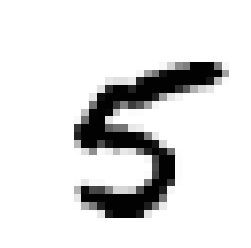

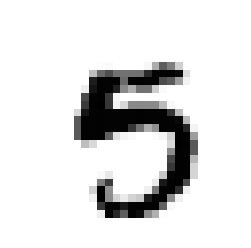

VISUALIZE AFTER NORMALIZATION


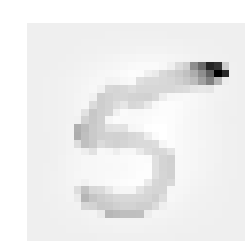

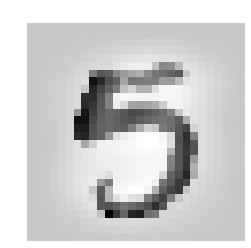

In [5]:
xTr, yTr = read_MNIST('Training')
print('Training images')
print(str(np.min(xTr[1]))+' ... '+str(np.max(xTr[1])))

xTr, mu, sigma = preprocess_data(xTr,visualize=True)

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [13]:
# run minibatch SGD for every combination of pams and record training/val accuracy
def tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt):
    
    obj=dict()
    trAcc=dict()
    model=dict()
    valAcc=dict()

    for lmbda in lambdas:
        for lr in sgd_opt['lrs']:
            for bsize in sgd_opt['bsizes']:
                for maxepoch in sgd_opt['maxepochs']:
                    for objTol in sgd_opt['objTols']:
                        params_key = str(lmbda)+"-"+str(lr)+"-"+str(bsize)+"-"+str(maxepoch)+"-"+str(objTol)
                        model[params_key], obj[params_key],trAcc[params_key] = minibatch_sgd(xTr,yTr,xVl,yVl,lmbda, lr,maxepoch,bsize,objTol=objTol, verbose=sgd_opt['verbose'])
                        valAcc[params_key] = accuracy(xVl,model[params_key],yVl)
                        if sgd_opt['verbose'] >= 0:
                            print('-- lambda=%.5f, lr=%.2f, bsize = %d, maxepoch = %d, objTol = %.3f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,lr,bsize, maxepoch, objTol, valAcc[params_key],trAcc[params_key][-1]))
        
    return model, obj, trAcc, valAcc

When tunning, we will varie across a variety of the following params:

* lambdas: regularization parameter
* lrs: learning rates
* bsize: batchsize used in SGD
* maxepochs
* objTol


In [16]:
xTr, yTr = read_MNIST('Training')
xVl, yVl = read_MNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

lambdas = [0, 1e-5, 1e-4, 1e-2, 1.0, 10.0]
lrs = [.01, .05, .1]
bsizes = [32, 64, 96]
maxepochs = [10,30,60]
objTols = [0.01, 0.001]

sgd_opt = {'bsizes':bsizes, 'maxepochs':maxepochs, 'lrs':lrs,'objTols':objTols, 'verbose':0}

model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

#Reference: https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
def keywithmaxval(d):
    """ a) create a list of the dict's keys and values; 
     b) return the key with the max value"""  

    k=list(d.keys())
    v=list(d.values())

    return k[v.index(max(v))]

best=keywithmaxval(valAcc)



-- lambda=0.00000, lr=0.01, bsize = 32, maxepoch = 10, objTol = 0.010, val Acc = 0.9096  (tr Acc = 0.9139)
-- lambda=0.00000, lr=0.01, bsize = 32, maxepoch = 10, objTol = 0.001, val Acc = 0.9097  (tr Acc = 0.9141)
-- lambda=0.00000, lr=0.01, bsize = 32, maxepoch = 30, objTol = 0.010, val Acc = 0.9089  (tr Acc = 0.9143)
-- lambda=0.00000, lr=0.01, bsize = 32, maxepoch = 30, objTol = 0.001, val Acc = 0.9089  (tr Acc = 0.9137)
-- lambda=0.00000, lr=0.01, bsize = 32, maxepoch = 60, objTol = 0.010, val Acc = 0.9095  (tr Acc = 0.9142)
-- lambda=0.00000, lr=0.01, bsize = 32, maxepoch = 60, objTol = 0.001, val Acc = 0.9094  (tr Acc = 0.9141)
-- lambda=0.00000, lr=0.01, bsize = 64, maxepoch = 10, objTol = 0.010, val Acc = 0.8996  (tr Acc = 0.9039)
-- lambda=0.00000, lr=0.01, bsize = 64, maxepoch = 10, objTol = 0.001, val Acc = 0.9002  (tr Acc = 0.9038)
-- lambda=0.00000, lr=0.01, bsize = 64, maxepoch = 30, objTol = 0.010, val Acc = 0.9001  (tr Acc = 0.9039)
-- lambda=0.00000, lr=0.01, bsize = 6

-- lambda=0.00001, lr=0.05, bsize = 32, maxepoch = 60, objTol = 0.001, val Acc = 0.9161  (tr Acc = 0.9341)
-- lambda=0.00001, lr=0.05, bsize = 64, maxepoch = 10, objTol = 0.010, val Acc = 0.9146  (tr Acc = 0.9268)
-- lambda=0.00001, lr=0.05, bsize = 64, maxepoch = 10, objTol = 0.001, val Acc = 0.9143  (tr Acc = 0.9264)
-- lambda=0.00001, lr=0.05, bsize = 64, maxepoch = 30, objTol = 0.010, val Acc = 0.9150  (tr Acc = 0.9266)
-- lambda=0.00001, lr=0.05, bsize = 64, maxepoch = 30, objTol = 0.001, val Acc = 0.9150  (tr Acc = 0.9262)
-- lambda=0.00001, lr=0.05, bsize = 64, maxepoch = 60, objTol = 0.010, val Acc = 0.9138  (tr Acc = 0.9265)
-- lambda=0.00001, lr=0.05, bsize = 64, maxepoch = 60, objTol = 0.001, val Acc = 0.9137  (tr Acc = 0.9264)
-- lambda=0.00001, lr=0.05, bsize = 96, maxepoch = 10, objTol = 0.010, val Acc = 0.9130  (tr Acc = 0.9213)
-- lambda=0.00001, lr=0.05, bsize = 96, maxepoch = 10, objTol = 0.001, val Acc = 0.9124  (tr Acc = 0.9214)
-- lambda=0.00001, lr=0.05, bsize = 9

-- lambda=0.00010, lr=0.10, bsize = 64, maxepoch = 60, objTol = 0.010, val Acc = 0.9151  (tr Acc = 0.9334)
-- lambda=0.00010, lr=0.10, bsize = 64, maxepoch = 60, objTol = 0.001, val Acc = 0.9150  (tr Acc = 0.9336)
-- lambda=0.00010, lr=0.10, bsize = 96, maxepoch = 10, objTol = 0.010, val Acc = 0.9150  (tr Acc = 0.9294)
-- lambda=0.00010, lr=0.10, bsize = 96, maxepoch = 10, objTol = 0.001, val Acc = 0.9151  (tr Acc = 0.9300)
-- lambda=0.00010, lr=0.10, bsize = 96, maxepoch = 30, objTol = 0.010, val Acc = 0.9149  (tr Acc = 0.9293)
-- lambda=0.00010, lr=0.10, bsize = 96, maxepoch = 30, objTol = 0.001, val Acc = 0.9149  (tr Acc = 0.9301)
-- lambda=0.00010, lr=0.10, bsize = 96, maxepoch = 60, objTol = 0.010, val Acc = 0.9147  (tr Acc = 0.9294)
-- lambda=0.00010, lr=0.10, bsize = 96, maxepoch = 60, objTol = 0.001, val Acc = 0.9148  (tr Acc = 0.9299)
-- lambda=0.01000, lr=0.01, bsize = 32, maxepoch = 10, objTol = 0.010, val Acc = 0.9061  (tr Acc = 0.9113)
-- lambda=0.01000, lr=0.01, bsize = 3

-- lambda=1.00000, lr=0.01, bsize = 96, maxepoch = 30, objTol = 0.001, val Acc = 0.8293  (tr Acc = 0.8315)
-- lambda=1.00000, lr=0.01, bsize = 96, maxepoch = 60, objTol = 0.010, val Acc = 0.8291  (tr Acc = 0.8317)
-- lambda=1.00000, lr=0.01, bsize = 96, maxepoch = 60, objTol = 0.001, val Acc = 0.8289  (tr Acc = 0.8316)
-- lambda=1.00000, lr=0.05, bsize = 32, maxepoch = 10, objTol = 0.010, val Acc = 0.8266  (tr Acc = 0.8325)
-- lambda=1.00000, lr=0.05, bsize = 32, maxepoch = 10, objTol = 0.001, val Acc = 0.8232  (tr Acc = 0.8258)
-- lambda=1.00000, lr=0.05, bsize = 32, maxepoch = 30, objTol = 0.010, val Acc = 0.8295  (tr Acc = 0.8318)
-- lambda=1.00000, lr=0.05, bsize = 32, maxepoch = 30, objTol = 0.001, val Acc = 0.8292  (tr Acc = 0.8316)
-- lambda=1.00000, lr=0.05, bsize = 32, maxepoch = 60, objTol = 0.010, val Acc = 0.8284  (tr Acc = 0.8315)
-- lambda=1.00000, lr=0.05, bsize = 32, maxepoch = 60, objTol = 0.001, val Acc = 0.8293  (tr Acc = 0.8316)
-- lambda=1.00000, lr=0.05, bsize = 6

-- lambda=10.00000, lr=0.10, bsize = 32, maxepoch = 30, objTol = 0.010, val Acc = 0.7559  (tr Acc = 0.7613)
-- lambda=10.00000, lr=0.10, bsize = 32, maxepoch = 30, objTol = 0.001, val Acc = 0.7553  (tr Acc = 0.7603)
-- lambda=10.00000, lr=0.10, bsize = 32, maxepoch = 60, objTol = 0.010, val Acc = 0.7553  (tr Acc = 0.7609)
-- lambda=10.00000, lr=0.10, bsize = 32, maxepoch = 60, objTol = 0.001, val Acc = 0.7548  (tr Acc = 0.7613)
-- lambda=10.00000, lr=0.10, bsize = 64, maxepoch = 10, objTol = 0.010, val Acc = 0.7261  (tr Acc = 0.7317)
-- lambda=10.00000, lr=0.10, bsize = 64, maxepoch = 10, objTol = 0.001, val Acc = 0.7413  (tr Acc = 0.7452)
-- lambda=10.00000, lr=0.10, bsize = 64, maxepoch = 30, objTol = 0.010, val Acc = 0.7552  (tr Acc = 0.7617)
-- lambda=10.00000, lr=0.10, bsize = 64, maxepoch = 30, objTol = 0.001, val Acc = 0.7550  (tr Acc = 0.7608)
-- lambda=10.00000, lr=0.10, bsize = 64, maxepoch = 60, objTol = 0.010, val Acc = 0.7550  (tr Acc = 0.7613)
-- lambda=10.00000, lr=0.10,

Parameters and perfomance of the best model:
(Parameteters format: lmbda-lr-bsize-maxepoch-objTol)

In [18]:
print("Parameters:")
print(best)
print("Performance:")
print('val Acc = %.4f  (tr Acc = %.4f)'%(valAcc[best],trAcc[best][-1]))


Parameters:
0.0001-0.1-32-30-0.001
Performance:
val Acc = 0.9175  (tr Acc = 0.9396)


_What is the impact of regularization?_

From a first glance, we observe that regularization is not very important when training our model (lambda ideal is 0.0001).

Would be look to look at the top 10 best models, and study regularization there. Looking at the top results, we observe that regularization is usually very low or 0.

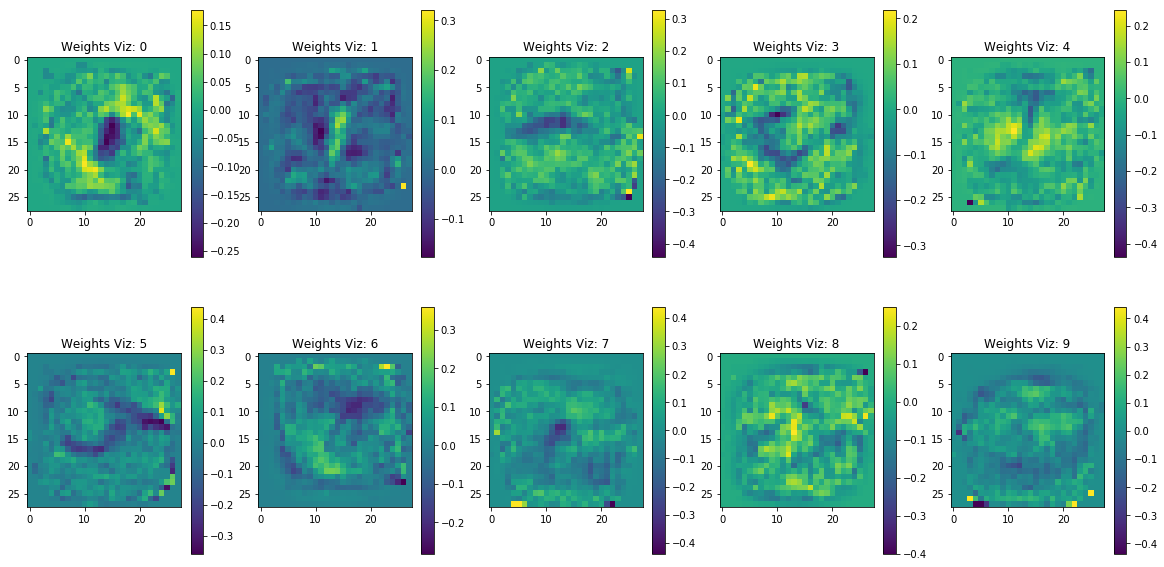

In [38]:
#Visualize the weights of the best model for the Large dataset

w=model[best]

ind = 0
fig = plt.figure(figsize=(20,10))

for cn in class_names:
    plt.subplot(2,5,ind+1)
    plt.imshow(w[-28**2:, ind].reshape(28, 28))
    plt.title("Weights Viz: "+cn)
    plt.colorbar()
    ind += 1

plt.show()


_What do you observe about the visualized weights for each class label?_

The images presented give as an idea of the importance (weight) of each pixel for each class label. This is a very interesting as we can have a visual representation of the weights.

For some classes it is possible to identify patterns, for others it is more difficult.
In order to get an idea of what the images are showing, we should try to identify where are the pizels with high absolute values of their respective weights (those pixels will ponder more significantly than those with wheights close to zero) in the estimation of the predicted label.

For example, we observe a clearn patter for class label 0. We can identify that, pixels in the center of the image (where the whole of the zero usually goes), have very negative weights compared to all others. We can also observe that pixels in the area where usually the line of a 0 is drawn have positive weights. 

Something similar happens with class number 1. There is a vertical line of pixels in the center, signaling that the weights of those pixels is higher compared to others when trying to identify an image with a number 1.

Lastly, its also interesting to notice why are weights images for other classes harder to interpret. This is mainly because there is so much training data, that the model learned to adapt very well to all of them, and hence, it is not asking a very strict shape or position for the numbers being drawn. In other words, for numbers that are usually drawn in a wider variety of ways (number 8 is usually drawn with more "variance" than 0), the weights of pixels are more "distributed" in the space of pixels.


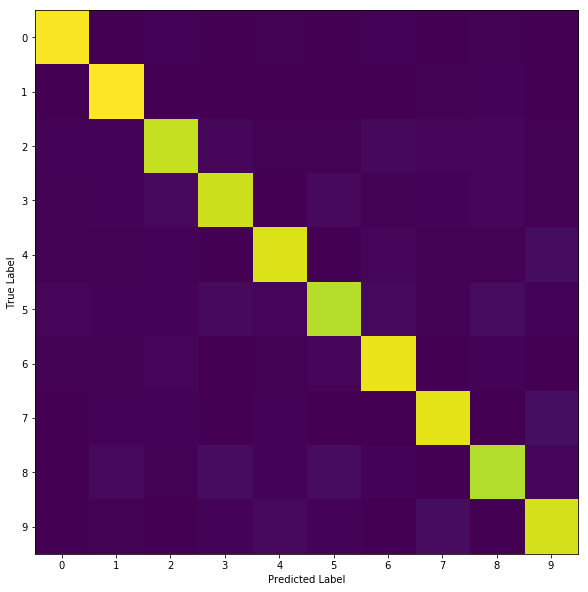

In [19]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

#Get the names for the tickmarks of the confusion matrix
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(10):
        return class_names[int(tick_val)]
    else:
        return ''

def build_confusion_matrix(y_hat,y):
    conf_mat = np.zeros((10,10))
    
    for i in range(10):
        for j in range(10):
            #Put the number of datapoints that had class i, and predicted class j in that entry of conf matrix
            conf_mat[i,j] = np.sum(np.equal(y,i).astype(np.float32)*np.equal(y_hat,j).astype(np.float32))
    
    for i in range(10):
        #normalize all the rows to sum to 1
        conf_mat[i,:] = conf_mat[i,:]/np.sum(conf_mat[i,:])
    
    #Make plot and add tick for each class
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.xticks(range(10))
    plt.yticks(range(10))

    #add labels and display matrix
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    ax.imshow(conf_mat)
    plt.show()
    
    return conf_mat

#Visualize Confusion Matrix for best model
yVl_pred = np.argmax(infer(xVl,model[best]),axis=1)
conv_mat = build_confusion_matrix(yVl_pred,np.argmax(yVl,axis=1))

_What do you observe in the confusion matrix?_

The confusion matrix is clear in informing that the predictions were done, in general, in an accurate way: the diagonal with high values (yellow colors) is indicating that, for data points true labelled with class i, most of the time we classified it with j=i. Hence, points (1,1), (2,2), ... (9,9), are very bright.

The confusion matrix also allow us to identify where did we make mistakes. Lets have a look:
- First of all, 0s and 1s have very bright colors: we dont do many mistakes here.
- When doing error on 2s, most error confuse 2s with 3s (lighter areas of purple)
- 3s are sometimes confused by 5 .
- 4s are very rarely confused. Sometimes confusef for 9.
- 5s are confused by 3s and 8s.
- 6s, 7s and 9s are rarely confused.
- 8s are confused with 3s and 5s.

All previous errors make sense with intuition in the sense that shapes of those numbers (true vs predicted) are similar


Select the best model and use it to generate predictions for test data (to be submitted to Kaggle)

In [20]:
xTe = read_MNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./large_submission.csv', final_preds)

Now we will repeat this experiment with the small training set

In [23]:
xTr, yTr = read_MNIST('Training', load_small=True)
xVl, yVl = read_MNIST('Validation')
xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

lambdas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
lrs = [.01, .05, .1]
bsizes = [3,6,12]
maxepochs = [10,30,60,100]
objTols = [0.01, 0.001]

sgd_opt = {'bsizes':bsizes, 'maxepochs':maxepochs, 'lrs':lrs,'objTols':objTols, 'verbose':0}

model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

# Add your code to select the best model for the small dataset
best=keywithmaxval(valAcc)

-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 10, objTol = 0.010, val Acc = 0.5706  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 10, objTol = 0.001, val Acc = 0.5692  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 30, objTol = 0.010, val Acc = 0.5701  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 30, objTol = 0.001, val Acc = 0.5689  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 60, objTol = 0.010, val Acc = 0.5673  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 60, objTol = 0.001, val Acc = 0.5694  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 100, objTol = 0.010, val Acc = 0.5688  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 3, maxepoch = 100, objTol = 0.001, val Acc = 0.5698  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 6, maxepoch = 10, objTol = 0.010, val Acc = 0.5604  (tr Acc = 1.0000)
-- lambda=0.00000, lr=0.01, bsize = 6, maxep

-- lambda=0.00001, lr=0.01, bsize = 3, maxepoch = 60, objTol = 0.001, val Acc = 0.5698  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 3, maxepoch = 100, objTol = 0.010, val Acc = 0.5699  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 3, maxepoch = 100, objTol = 0.001, val Acc = 0.5714  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxepoch = 10, objTol = 0.010, val Acc = 0.5615  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxepoch = 10, objTol = 0.001, val Acc = 0.5626  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxepoch = 30, objTol = 0.010, val Acc = 0.5621  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxepoch = 30, objTol = 0.001, val Acc = 0.5615  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxepoch = 60, objTol = 0.010, val Acc = 0.5638  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxepoch = 60, objTol = 0.001, val Acc = 0.5630  (tr Acc = 1.0000)
-- lambda=0.00001, lr=0.01, bsize = 6, maxep

-- lambda=0.00010, lr=0.01, bsize = 6, maxepoch = 60, objTol = 0.010, val Acc = 0.5630  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 6, maxepoch = 60, objTol = 0.001, val Acc = 0.5615  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 6, maxepoch = 100, objTol = 0.010, val Acc = 0.5626  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 6, maxepoch = 100, objTol = 0.001, val Acc = 0.5639  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 12, maxepoch = 10, objTol = 0.010, val Acc = 0.5438  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 12, maxepoch = 10, objTol = 0.001, val Acc = 0.5481  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 12, maxepoch = 30, objTol = 0.010, val Acc = 0.5614  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 12, maxepoch = 30, objTol = 0.001, val Acc = 0.5423  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 12, maxepoch = 60, objTol = 0.010, val Acc = 0.5505  (tr Acc = 1.0000)
-- lambda=0.00010, lr=0.01, bsize = 12,

-- lambda=0.00100, lr=0.01, bsize = 12, maxepoch = 30, objTol = 0.010, val Acc = 0.5476  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.01, bsize = 12, maxepoch = 30, objTol = 0.001, val Acc = 0.5477  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.01, bsize = 12, maxepoch = 60, objTol = 0.010, val Acc = 0.5511  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.01, bsize = 12, maxepoch = 60, objTol = 0.001, val Acc = 0.5524  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.01, bsize = 12, maxepoch = 100, objTol = 0.010, val Acc = 0.5447  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.01, bsize = 12, maxepoch = 100, objTol = 0.001, val Acc = 0.5496  (tr Acc = 0.9667)
-- lambda=0.00100, lr=0.05, bsize = 3, maxepoch = 10, objTol = 0.010, val Acc = 0.5814  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.05, bsize = 3, maxepoch = 10, objTol = 0.001, val Acc = 0.5389  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.05, bsize = 3, maxepoch = 30, objTol = 0.010, val Acc = 0.5646  (tr Acc = 1.0000)
-- lambda=0.00100, lr=0.05, bsize = 3,

-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 10, objTol = 0.001, val Acc = 0.5784  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 30, objTol = 0.010, val Acc = 0.5565  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 30, objTol = 0.001, val Acc = 0.5574  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 60, objTol = 0.010, val Acc = 0.5571  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 60, objTol = 0.001, val Acc = 0.5601  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 100, objTol = 0.010, val Acc = 0.5731  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 3, maxepoch = 100, objTol = 0.001, val Acc = 0.5630  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 6, maxepoch = 10, objTol = 0.010, val Acc = 0.5741  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 6, maxepoch = 10, objTol = 0.001, val Acc = 0.5652  (tr Acc = 1.0000)
-- lambda=0.01000, lr=0.05, bsize = 6, maxep

-- lambda=0.10000, lr=0.05, bsize = 3, maxepoch = 100, objTol = 0.001, val Acc = 0.5721  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 10, objTol = 0.010, val Acc = 0.5707  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 10, objTol = 0.001, val Acc = 0.5765  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 30, objTol = 0.010, val Acc = 0.5646  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 30, objTol = 0.001, val Acc = 0.5769  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 60, objTol = 0.010, val Acc = 0.5739  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 60, objTol = 0.001, val Acc = 0.5819  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 100, objTol = 0.010, val Acc = 0.5709  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 6, maxepoch = 100, objTol = 0.001, val Acc = 0.5761  (tr Acc = 1.0000)
-- lambda=0.10000, lr=0.05, bsize = 12, max

-- lambda=1.00000, lr=0.05, bsize = 6, maxepoch = 60, objTol = 0.010, val Acc = 0.5742  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 6, maxepoch = 60, objTol = 0.001, val Acc = 0.5741  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 6, maxepoch = 100, objTol = 0.010, val Acc = 0.5748  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 6, maxepoch = 100, objTol = 0.001, val Acc = 0.5737  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 12, maxepoch = 10, objTol = 0.010, val Acc = 0.5611  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 12, maxepoch = 10, objTol = 0.001, val Acc = 0.5749  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 12, maxepoch = 30, objTol = 0.010, val Acc = 0.5648  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 12, maxepoch = 30, objTol = 0.001, val Acc = 0.5772  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 12, maxepoch = 60, objTol = 0.010, val Acc = 0.5664  (tr Acc = 1.0000)
-- lambda=1.00000, lr=0.05, bsize = 12,

-- lambda=10.00000, lr=0.05, bsize = 12, maxepoch = 30, objTol = 0.010, val Acc = 0.5654  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.05, bsize = 12, maxepoch = 30, objTol = 0.001, val Acc = 0.5547  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.05, bsize = 12, maxepoch = 60, objTol = 0.010, val Acc = 0.5474  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.05, bsize = 12, maxepoch = 60, objTol = 0.001, val Acc = 0.5625  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.05, bsize = 12, maxepoch = 100, objTol = 0.010, val Acc = 0.5475  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.05, bsize = 12, maxepoch = 100, objTol = 0.001, val Acc = 0.5585  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.10, bsize = 3, maxepoch = 10, objTol = 0.010, val Acc = 0.4305  (tr Acc = 0.7667)
-- lambda=10.00000, lr=0.10, bsize = 3, maxepoch = 10, objTol = 0.001, val Acc = 0.4394  (tr Acc = 0.8333)
-- lambda=10.00000, lr=0.10, bsize = 3, maxepoch = 30, objTol = 0.010, val Acc = 0.5548  (tr Acc = 1.0000)
-- lambda=10.00000, lr=0.10, 

Parameters and perfomance of the best model for small training data:
(Parameteters format: lmbda-lr-bsize-maxepoch-objTol)

In [32]:
print("Parameters:")
print(best)
print("Performance:")
print('val Acc = %.4f  (tr Acc = %.4f)'%(valAcc[best],trAcc[best][-1]))

Parameters:
0.0001-0.1-12-100-0.001
Performance:
val Acc = 0.5860  (tr Acc = 1.0000)


We observe training accuracy is 1! Which is a sign of overfitting.

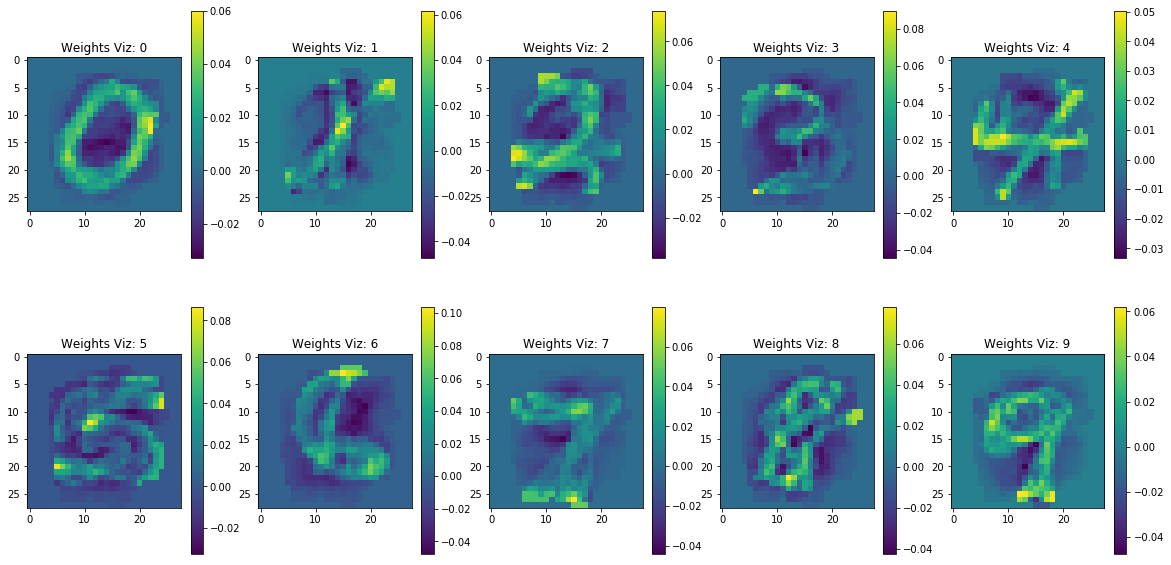

In [27]:
#Visualize the weights of the best model for the small dataset

w=model[best]

ind = 0
fig = plt.figure(figsize=(20,10))

for cn in class_names:
    plt.subplot(2,5,ind+1)
    plt.imshow(w[-28**2:, ind].reshape(28, 28))
    plt.title("Weights Viz: "+cn)
    plt.colorbar()
    ind += 1

plt.show()

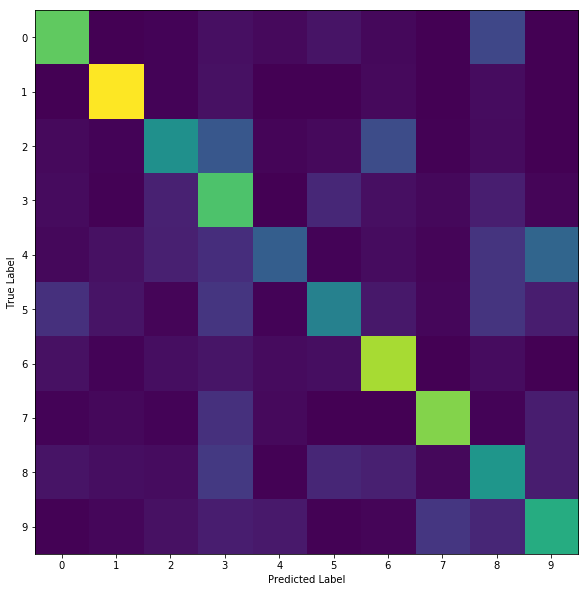

In [28]:
#Visualize Confusion Matrix for best model for small dataset
yVl_pred = np.argmax(infer(xVl,model[best]),axis=1)
conv_mat = build_confusion_matrix(yVl_pred,np.argmax(yVl,axis=1))

_What do you observe about the weight visualization and confusion matrix compared to the large training data setting?_

We observe two things:
1. The visual representations of weights are more similar to numbers
2. We make significant more error in our predictions (colors through the diagonal are signigicantly lower than before).

Why does 1 occur? Due to the fact that our training sample is so small, our model learns from only a small samples of "ways of writing numbers". Hence, it expects very precise/unique ways of writing an 8, for example, which correlates with the fact that the weights are so strong around specific pixels. In other words, weights are the proxy on how the model understands how to read new images of numbers. When the sample was bigger, the model understood that there are lots of variations in the ways of writing a 8, and hence consider a more significant number of pixels, and gave them all more weight (it distributed the power of weights through the different features).

Why did 2 occur? Related to the previous explanation, the fact that we have less data implies that our models training is poorer, and hence, is less able to predict labels precisely.

In [30]:
xTe = read_MNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./small_submission.csv', final_preds)
